# Full Bayesian inference using linear approximation of dynamics

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.integrate import odeint

from numpy import random

from gMLV import *

def set_all_seeds(seed):
    np.random.seed(seed)
    random.seed(seed)

# some plotting functions

cols = ["red", "green", "blue", "royalblue","orange", "black", "salmon", "forestgreen", "steelblue", "slateblue","gold", "palegreen"]

def plot_gMLV(yobs, sobs, timepoints):
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]')
    if sobs.shape[1] > 0:
        for metabolite_idx in range(sobs.shape[1]):
            axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].set_xlabel('time')
        axs[1].set_ylabel('[metabolite]');

def plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, timepoints):
    # plot the fit
    #fig, axs = plt.subplots(1, 2, layout='constrained')
    fig, axs = plt.subplots(1, 2)  
    for species_idx in range(yobs.shape[1]):
        axs[0].plot(timepoints, yobs[:, species_idx], color=cols[species_idx])
        axs[0].plot(timepoints, yobs_h[:, species_idx], '--', color=cols[species_idx])
    axs[0].set_xlabel('time')
    axs[0].set_ylabel('[species]');

    for metabolite_idx in range(sobs.shape[1]):
        axs[1].plot(timepoints, sobs[:, metabolite_idx], color=cols[metabolite_idx])
        axs[1].plot(timepoints, sobs_h[:, metabolite_idx], '--', color=cols[metabolite_idx])
    axs[1].set_xlabel('time')
    axs[1].set_ylabel('[metabolite]');

def compare_params(mu=None, M=None, alpha=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat/mu:")
        print(np.array(mu[1]))
        print(np.array(mu[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[1]), markerfmt="D")
        ax.stem(np.arange(0,len(mu[0]), dtype="int32"), np.array(mu[0]), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat/M:")
        print(np.round(np.array(M[1]), decimals=2))
        print("\n",np.array(M[0]))

        #fig, ax = plt.subplots()
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[1]).flatten(), markerfmt="D")
        #ax.stem(np.arange(0, M[0].shape[0] ** 2), np.array(M[0]).flatten(), markerfmt="X")
        #ax.set_ylabel('M[i,j]');

        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        ax.stem(np.arange(0, Ns), np.array(M[1]).diagonal(), markerfmt="D")
        ax.stem(np.arange(0, Ns), np.array(M[0]).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M[0].shape[0]
        
        count = 0
        Mij = np.zeros([Ns*Ns - Ns])
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij[count] = np.array(M[0])[i,j]
                    Mij_h[count] = np.array(M[1])[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij.flatten(), markerfmt="D")
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
    if alpha is not None:
        print("\na_hat/a:")
        print(np.round(np.array(alpha[1]), decimals=2))
        print("\n",np.array(alpha[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, alpha[0].shape[0] * alpha[0].shape[1]), np.array(alpha[0]).flatten(), markerfmt="X")
        ax.set_ylabel('a[i,j]');

    if e is not None:
        print("\ne_hat/e:")
        print(np.round(np.array(e[1]), decimals=2))
        print("\n",np.array(e[0]))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[1]).flatten(), markerfmt="D")
        ax.stem(np.arange(0, e[0].shape[0]), np.array(e[0]).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');

def print_params(mu=None, M=None, e=None):
    # each argument is a tuple of true and predicted values
    if mu is not None:
        print("mu_hat:")
        print(np.array(mu))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0,len(mu), dtype="int32"), np.array(mu), markerfmt="X")
        ax.set_xlabel('i')
        ax.set_ylabel('mu[i]');

    if M is not None:
        print("\nM_hat:")
        print(np.round(np.array(M), decimals=2))

        fig, ax = plt.subplots()
        Ns = M.shape[0]
        ax.stem(np.arange(0, Ns), np.array(M).diagonal(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
        
        fig, ax = plt.subplots()
        Ns = M.shape[0]
        
        count = 0
        Mij_h = np.zeros([Ns*Ns - Ns])
        for i in range(Ns):
            for j in range(Ns):
                if i != j:
                    Mij_h[count] = np.array(M)[i,j]
                    count = count + 1
        
        ax.stem(np.arange(0, Ns*Ns - Ns), Mij_h.flatten(), markerfmt="X")
        ax.set_ylabel('M[i,i]');
    
    if e is not None:
        print("\ne_hat:")
        print(np.round(np.array(e), decimals=2))

        fig, ax = plt.subplots()
        ax.stem(np.arange(0, e.shape[0]), np.array(e).flatten(), markerfmt="X")
        ax.set_ylabel('e[i]');


# some MCMC analysis functions

def make_trace_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.plot(range(0,(iend-istart)),post)
    #print(var, np.median(post))
    return
    
def make_hist_plot(var,istart,iend):
    plt.figure()
    post = df[var][istart:iend]
    plt.hist(post)
    print(var, np.median(post))
    return
    
def get_Rhat(N,p1,p2):
    M = 2
    mean1 = np.mean(p1,axis=0)  
    mean2 = np.mean(p2,axis=0)  
    var1 = np.var(p1,axis=0)  
    var2 = np.var(p2,axis=0)
    
    meanM = (1/M)*(mean1 + mean2)
    
    B = (N/(M-1)) * (mean1-meanM)*(mean1-meanM) + (mean2-meanM)*(mean2-meanM)
    W = (1/M)*(var1 + var2)
    
    Vhat = ((N-1)/N)*W + ((M+1)/(M*N))*B
    
    Rhat = Vhat/W
    
    return Rhat

def get_horseshoe_tau(p0,D,sigma,n):
    return p0*sigma/( np.sqrt(n)*(D-p0) )

# extract gLV vectors and matrix from posterior sample
def extract_gLV_pars(est, num_species, e=False):

    # fill mu_h
    #mu_h = mu # if mu is fixed
    mu_h = est[0:num_species]
    est = est[num_species:]

    # fill M_h
    M_h = np.zeros([num_species,num_species])
    #np.fill_diagonal(M_h, M.diagonal() ) # if Md fixed
    np.fill_diagonal(M_h, -est[0:num_species])
    est = est[num_species:]

    count = 0
    #print("est:", est)
    for i in range(num_species):
        for j in range(num_species):
            if i != j:
                #M_h[i,j] = est[2*num_species + count]
                #M_h[i,j] = est[num_species + count]
                M_h[i,j] = est[count]
                count = count + 1

    #print(mu_h)
    #print(M_h)
    
    if e==False:
        return mu_h, M_h
    else:
        est = est[num_species*(num_species-1):]
        E_h = np.reshape(est[0:num_species],(num_species,1))

        return mu_h, M_h, E_h

def get_signal_matrix(npert, tp):
    # calculate signal matrix
    u = np.zeros([npert,len(times)])
    for i in range(npert):
        ui = (times >= tp[i][0]) & (times <= tp[i][1]) 
        u[i,:] = ui

    # remove last column of signal matrix
    u = u[:,:(u.shape[1]-1)]
    print('signal matrix:\n', u)
    return u
 
def visualise_chains():
    print("mu:",mu)
    for i in range(num_species):
        make_trace_plot("mu."+str(i+1),istart,iend)
        make_hist_plot("mu."+str(i+1),istart,iend)

    print("Md:",M.diagonal())
    for i in range(num_species):
        make_trace_plot("Md."+str(i+1),istart,iend)
        make_hist_plot("Md."+str(i+1),istart,iend)

    for i in range( num_species*(num_species - 1)):
        make_trace_plot("M."+str(i+1),istart,iend)
        make_hist_plot("M."+str(i+1),istart,iend)



In [2]:
   
set_all_seeds(1234)

Text(0.5, 1.0, 'sigma')

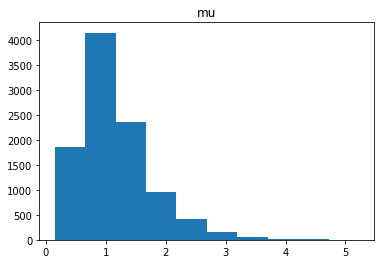

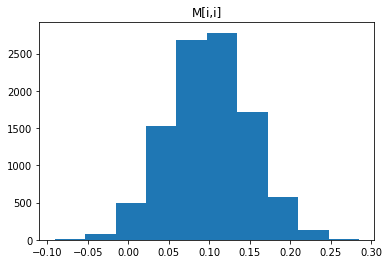

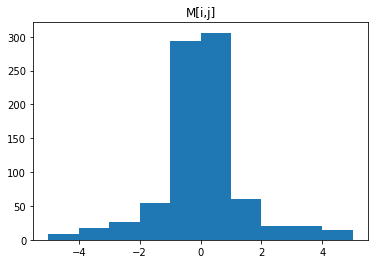

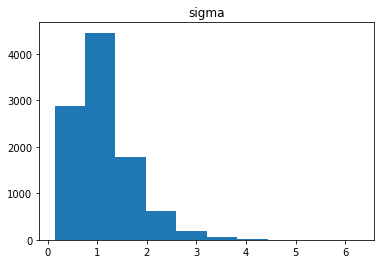

In [3]:
# Prior visualisation
# mu
x_mu = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_mu);
plt.title('mu')   

# Md
x_Md = np.random.normal(0.1,0.05,size=10000)
plt.figure()
plt.hist(x_Md);
plt.title('M[i,i]')    
    
# Shrinkage, M
tau0 = 0.001;
x_M = np.zeros([1000])
for i in range(1000):
    tau = np.random.standard_cauchy(size=1)
    lam = np.random.standard_cauchy(size=1)
    x_M[i] = np.random.normal(0,np.abs(lam)*np.abs(tau),size=1)
#print(x_M)
plt.figure()
plt.hist(x_M, range=(-5,5));
plt.title('M[i,j]');   

# sigma
x_sig = np.random.lognormal(0.01,0.5,size=10000)
plt.figure()
plt.hist(x_sig);
plt.title('sigma')  

In [4]:
def gLV_sde(y, mu, M, e=None):
    if e==None:
        return mu + M @ y
    else:
        return mu + M @ y

def sample_trajectories(nsample, times, num_species, mu_h, M_h, sigma_w):

    traj = np.zeros([nsample, len(times),num_species])
    for g in range(nsample):
        traj[g, 0,:] = yobs[0,:]
        for i in range(1,len(times)):
            dt = times[i]-times[i-1]
            f_x = gLV_sde(traj[g, i-1,:], mu_h, M_h)
    
            for j in range(num_species):
                traj[g,i,j] = traj[g,i-1,j] + f_x[j]*dt + np.random.normal(0, scale=np.sqrt(dt)*sigma_w)

    return traj
                

## M40 (no perturbations)

In [10]:
# Read in data
num_species=5

data = pd.read_csv("data/data-top5-M40.csv")
times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
#yobs = yobs.astype(float)

ymiss = yobs == 0
ymiss = ymiss.astype(int)

#yobs[yobs == 0] = np.nan
yobs[yobs == 0] = 1

#print(yobs)
#print(ymiss)
#print(np.log(yobs))

#print(data)
print("data:\n",yobs)

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_sde_nopert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": num_species,
                "T": len(times),   
                "x": np.log(yobs),
                "times": times,
                "xmiss": ymiss,
                "tau0": 0.01,
                #"sigma": 10,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters
post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)
    
mu_h, M_h = extract_gLV_pars(est, num_species)
    
print_params(mu=mu_h, M=M_h)

# plot trajectories corresponding to posterior median
sigma_w = np.median(df["sigma"].to_numpy())
nsample = 10
traj = sample_trajectories(nsample, times, num_species, mu_h, M_h, sigma_w)
                
#yobs_h = traj[0,:,:]
yobs_h = np.median(traj, axis=0)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

Error handling request
Traceback (most recent call last):
  File "/home/sandy/.local/lib/python3.8/site-packages/aiohttp/web_protocol.py", line 435, in _handle_request
    resp = await request_handler(request)
  File "/home/sandy/.local/lib/python3.8/site-packages/aiohttp/web_app.py", line 504, in _handle
    resp = await handler(request)
  File "/home/sandy/.local/lib/python3.8/site-packages/httpstan/views.py", line 253, in handle_show_params
    services_module = httpstan.models.import_services_extension_module(model_name)
  File "/home/sandy/.local/lib/python3.8/site-packages/httpstan/models.py", line 90, in import_services_extension_module
    module: ModuleType = importlib.util.module_from_spec(spec)  # type: ignore
  File "<frozen importlib._bootstrap>", line 556, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1101, in create_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
ImportError: /home/sandy/.cache/httpstan/4.

times:
 [30 31 33 35 37 38 39 40 42]
data:
 [[ 913  487  328  150   10]
 [ 901  476  354  119   28]
 [ 438 1117  229  162   39]
 [ 718  672  366  109    1]
 [ 614   83  352  297   53]
 [  80  475   71   52    1]
 [ 138  136   34   51   28]
 [ 376  185  189  273  166]
 [ 935  399  363  309   85]]


ValueError: The JSON document has an improper structure: missing or superfluous commas, braces, missing keys, etc.

## Q160 (no perturbations)

In [8]:
# Read in data
num_species=5

data = pd.read_csv("data/data-top5-Q160.csv")
times = data.iloc[:,0].to_numpy()
print("times:\n",times)
yobs = data.drop(columns=['timepoint', 'subjectID']).to_numpy()
#yobs = yobs.astype(float)

ymiss = yobs == 0
ymiss = ymiss.astype(int)

#yobs[yobs == 0] = np.nan
yobs[yobs == 0] = 1

#print(yobs)
#print(ymiss)
#print(np.log(yobs))

#print(data)
print("data:\n",yobs)

import nest_asyncio
nest_asyncio.apply()
import stan

f = open("model_sde_nopert.txt", "r")
gLV_code=f.read()

obs_data_lin = {"N": 5,
                "T": len(times),   
                "x": np.log(yobs),
                "times": times,
                "xmiss": ymiss,
                "tau0": 0.01,
                #"sigma": 10,
                } 

posterior = stan.build(gLV_code, data=obs_data_lin, random_seed=1)

sample_kwargs = {"num_samples": 1000, "num_chains": 2, "num_warmup": 5000 }
#fit = posterior.sample(num_chains=2, num_samples=500, num_warmup=10000, adapt={'delta':0.99})
fit = posterior.sample(**sample_kwargs);

#print(fit)

df = fit.to_frame()
print(df.describe().T)
#print(df.head())

post1 = df[df.columns[7:]][0:500].to_numpy()
post2 = df[df.columns[7:]][500:1000].to_numpy()
Rhat = get_Rhat(500, post1, post2)
print("Rhat:", Rhat)
istart = 0
iend = 2000

# plot the fit using median values of parameters
post1 = df[df.columns[7:]][0:iend].to_numpy()
est = np.median(post1,axis=0)
    
mu_h, M_h = extract_gLV_pars(est, num_species)
    
print_params(mu=mu_h, M=M_h)

# plot trajectories corresponding to posterior median
sigma_w = np.median(df["sigma"].to_numpy())
nsample = 10
traj = sample_trajectories(nsample, times, num_species, mu_h, M_h, sigma_w)
                
yobs_h = traj[0,:,:]
#yobs_h = np.median(traj, axis=0)

## PLOT RESULTS
# plot comparison of simulated and predicted timeseries
plot_fit_gMLV(yobs, yobs_h, sobs, sobs_h, times)

Error handling request
Traceback (most recent call last):
  File "/home/sandy/.local/lib/python3.8/site-packages/aiohttp/web_protocol.py", line 435, in _handle_request
    resp = await request_handler(request)
  File "/home/sandy/.local/lib/python3.8/site-packages/aiohttp/web_app.py", line 504, in _handle
    resp = await handler(request)
  File "/home/sandy/.local/lib/python3.8/site-packages/httpstan/views.py", line 253, in handle_show_params
    services_module = httpstan.models.import_services_extension_module(model_name)
  File "/home/sandy/.local/lib/python3.8/site-packages/httpstan/models.py", line 90, in import_services_extension_module
    module: ModuleType = importlib.util.module_from_spec(spec)  # type: ignore
  File "<frozen importlib._bootstrap>", line 556, in module_from_spec
  File "<frozen importlib._bootstrap_external>", line 1101, in create_module
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
ImportError: /home/sandy/.cache/httpstan/4.

times:
 [ 7 10 13 15 16 17 20 21]
data:
 [[1266  734  270  300  120]
 [ 730   58 1002   26   79]
 [ 905  964  282  147    1]
 [ 460  189  114  304    1]
 [ 698  733   82   71   11]
 [1026  666  119  313  136]
 [ 328  451  870  644   87]
 [1124 1499  526  186  104]]


ValueError: The JSON document has an improper structure: missing or superfluous commas, braces, missing keys, etc.